<a name="Home"></a>
# Caravan Customer Identification Study - Deep Learning Approach

- Author: Tommy Lam
- Date: 22 Apr, 2020
- Programming language: Python
- Data Source: The CoIL Challenge 2000 http://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/

Customer identification, one of the most common applications of machine learning in the business area, aims to identify potential customers. This would enhance the effectiveness of marketing campaigns, prevent the waste of resources on focusing on the wrong target group.


In the previous part of this project, I have performed exploratory data analysis (EDA) on the dataset to have a big picture on the dataset and see how is the target group (caravan users) looks like. After the EDA, I have performed some basic machine learning over the dataset (logistic regression, KNN classification and random forest). The project can be viewed here.


In this project, I will demonstrate a higher level of classification on the caravan customer prediction with deep learning techniques. 

## Objective
The goal of this project is to predict the potential user of caravan based on sociodemographic and product usage attributes. 

## Previous result
In the previous section, I have used several machine learning algorithms - logistic regression, random forest and KNN classification. They did not give a robust result unfortunately hence I will explore this topic with a deep learning approach.

## Difficulties
Our target users, the caravan users, are the minority among the population, i.e. only 6% of people are the caravan users in this dataset.

This is a typical *imbalanced classification* problem similar to fraud detection, spam filtering, subscription churn where the target group is the minority. It is hard to find them out since the predictions generally give negative results to achieve high accuracy. 

There are several ways to handle the imbalanced classification:
1. Scale up the minority group 
2. Scale down the majority group
3. Use a penalizing model (such as SVC)
4. Use a tree-based algorithm (Decision Tree, Random Forest)

In this project, I will scale up the minority group such that the ratio of caravan customer would be 1:1. After that, I will build a neural network model to determine whether if a person is potentially a caravan user, based on sociodemographic and product usage attributes.




# Table of Contents
### [Libraries Required](#Libraries)

### [Data Import](#import)

### [Data Wrangling](#wrangling)
* Values mapping
* Minority group upsampling

### [Data Modelling](#modelling)

* [Neural Network Model](#NN)

* [Logistic regression classification](#logistic)

* [Support Vector Machine SVM](#svm)

### [Summary](#summary)



<a name="Libraries"></a>
# Import libraries 
These are all the libraries we may need in this project.

In [ ]:
# Basic data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Data processing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [ ]:
# Deep learning setup
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import plot_model

Using TensorFlow backend.


In [ ]:
# Model evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[Back to top](#Home)

<a name="import"></a>
# Load the data

The dataset includes two main components. The first one is whether the user is a caravan user. This would be our target variable in this project. The second part consists of 85 attributes, containing sociodemographic data and product ownership information.

Here are 3 data files we used in this project.
1. TICDATA2000.txt: Dataset to train and validate prediction models and build a description (5822 customer records). Each record consists of 86 attributes, containing sociodemographic data (attribute 1-43) and product ownership (attributes 44-86). The sociodemographic data is derived from zip codes. All customers living in areas with the same zip code have the same sociodemographic attributes. Attribute 86, "CARAVAN: Number of mobile home policies", is the target variable.
2. TICEVAL2000.txt: Dataset for predictions (4000 customer records). It has the same format as TICDATA2000.txt, only the target is missing. Participants are supposed to return the list of predicted targets only. All datasets are in tab-delimited format. The meaning of the attributes and attribute values is given below.
3. TICTGTS2000.txt Targets for the evaluation set.

The data dictionary, also called a Data Definition Matrix, provides detailed information about the business data. It is included in the following link:
Data dictionary: https://kdd.ics.uci.edu/databases/tic/dictionary.txt

In [ ]:
train_data = pd.read_csv('data/ticdata2000.txt',header=None, delim_whitespace= True)
predict_data = pd.read_csv('data/ticeval2000.txt',header=None, delim_whitespace= True)
target_data = pd.read_csv('data/tictgts2000.txt',header=None, delim_whitespace= True)

In [ ]:
train_data.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
predict_data.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,33,1,4,2,8,0,6,0,3,5,0,4,1,1,8,2,2,6,0,0,1,2,6,1,0,2,1,5,3,1,8,8,1,1,8,1,3,3,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,6,1,3,2,2,0,5,0,4,5,2,2,1,4,5,5,4,0,5,0,0,4,0,0,4,3,0,2,1,3,6,9,0,0,7,2,1,1,5,4,...,0,6,0,4,0,0,0,0,0,3,0,0,0,4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0


In [ ]:
target_data.head(2)

,0
0,0
1,1


[Back to top](#Home)

<a name='wrangling'></a>
# Data Wrangling


First of all, I redefine the column names in order to facilitate the data manipulation in python. 
V1 to V85 are the attributes for each of the records and the V86 is our target variable.

In [ ]:
length = train_data.shape[1]
name_list = ['V'+str(x) for x in range(1,length+1)]
train_data.columns = name_list
predict_data.columns = name_list[0:-1]
target_data.columns = ['V86']

In [ ]:
train_data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Some of the data are represented by coding, for example, the age-group is presented as 1 to 6. Since these variables are continuous and their values would be meaningful in the models, they are converted into mean values of each group.

In [ ]:
age = dict(zip([1,2,3,4,5,6] ,[25,35,45,55,65,75]))                                             # age
L3 = dict(zip([0,1,2,3,4,5,6,7,8,9],[0,5.5,17,30,43,56,69,82,94,100]))                          # MGODRK Roman catholic 
L4 = dict(zip([0,1,2,3,4,5,6,7,8,9],[0,25,74.5,149.5,349.5,749.5,2999.5,7499.5,14999.5,20000])) # Income

In [ ]:
# Data mapping
train_data['V4'] = train_data['V4'].apply(lambda x: age[x])
train_data['V6'] = train_data['V6'].apply(lambda x: L3[x])
train_data['V44'] = train_data['V44'].apply(lambda x: L4[x])

predict_data['V4'] = predict_data['V4'].apply(lambda x: age[x])
predict_data['V6'] = predict_data['V6'].apply(lambda x: L3[x])
predict_data['V44'] = predict_data['V44'].apply(lambda x: L4[x])

In [ ]:
train_data[['V4','V6','V42']].head()

,V4,V6,V42
0,35,0.0,4
1,35,5.5,5
2,35,0.0,3
3,45,17.0,4
4,35,5.5,6


## Resampling
When we look at the distribution of the target data, i.e. Caravan user, we can observe the huge gap between users and non-users. It is a typical imbalanced classification problem that the target group is uncommon (0-10% of the total population), such as error detection, customer churning prediction, etc.

If we run the models directly over the imbalanced data, the results would be negative in general to achieve high accuracy. Therefore, we need to restructure our database. The minority group, the caravan users, would be scaled up by resampling such that the ratio of users to non-users will be even.

In [ ]:
train_data.V86.value_counts()

0    5474
1     348
Name: V86, dtype: int64

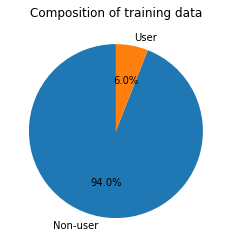

In [ ]:
labels = 'Non-user','User'
plt.pie(train_data.V86.value_counts(), 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90)
plt.title('Composition of training data')
plt.show()

In [ ]:
target_data.V86.value_counts()

0    3762
1     238
Name: V86, dtype: int64

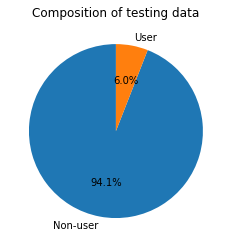

In [ ]:
labels = 'Non-user','User'
plt.pie(target_data.V86.value_counts(), 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90)
plt.title('Composition of testing data')
plt.show()

Our target group, caravan users composed of only 6% of the whole population.

Therefore, I will upscale the minority group in the following steps such that the ratio of caravan users and non-users will be 1:1.

In [ ]:
# Separate majority and minority classes
df_majority = train_data[train_data.V86==0]
df_minority = train_data[train_data.V86==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5474)    # to match majority class
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.V86.value_counts()


1    5474
0    5474
Name: V86, dtype: int64

So now the ratio of user to non-user are even. The data are ready for further processing.

The training dataset will be randomly split into training and validation set.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df_upsampled.iloc[:,0:85], df_upsampled.iloc[:,85:86], test_size=0.3)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (7663, 85)
x_test shape: (3285, 85)
y_train shape: (7663, 1)
y_test shape: (3285, 1)


The next step will be the implementation of deep learning model on the training and validation set.

[Back to top](#Home)

<a name='modelling'></a>
# Data Modelling

<a name='NN'></a>
## Neural Network model

### Model Setup
In this section, I will build a neural network model with 3 hidden layers with Keras. Keras is a python library that can provide a simple way to construct deep learning models. We will use the training set to train the model and use the validation set to make sure the model is trained in the right direction. The ratio of the training set to testing set is 7:3.

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=85, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Model Structure
The following graph shows the structure of the neural network model with 3 hidden layers.

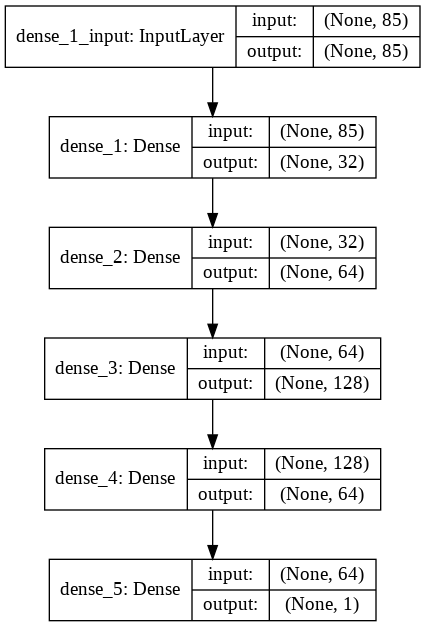

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

### Model Training
Let's train the model. The model took around 50 epochs to converge to the optimum result and the whole training process took only 30 seconds!

In [ ]:
%%time
epochs = 50
# batch_size = 20
print('Train...')
history = model.fit(x_train, y_train,
#           batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train...
Train on 7663 samples, validate on 3285 samples
Epoch 1/50
7663/7663 [==============================] - 1s 78us/step - loss: 0.6414 - accuracy: 0.6490 - val_loss: 0.5984 - val_accuracy: 0.6709
Epoch 2/50
7663/7663 [==============================] - 0s 57us/step - loss: 0.5525 - accuracy: 0.7167 - val_loss: 0.5374 - val_accuracy: 0.7148
Epoch 3/50
7663/7663 [==============================] - 0s 57us/step - loss: 0.5126 - accuracy: 0.7444 - val_loss: 0.5111 - val_accuracy: 0.7364
Epoch 4/50
7663/7663 [==============================] - 0s 57us/step - loss: 0.4712 - accuracy: 0.7698 - val_loss: 0.4665 - val_accuracy: 0.7738
Epoch 5/50
7663/7663 [==============================] - 0s 57us/step - loss: 0.4301 - accuracy: 0.7968 - val_loss: 0.4255 - val_accuracy: 0.7988
Epoch 6/50
7663/7663 [==============================] - 0s 56us/step - loss: 0.4005 - accuracy: 0.8146 - val_loss: 0.4115 - val_accuracy: 0.8018
Epoch 7/50
7663/7663 [==============================] - 0s 59us/step - lo

In [ ]:
score, acc = model.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

3285/3285 [==============================] - 0s 24us/step
Test score: 0.15089635097590393
Test accuracy: 0.9595129489898682


The validation accuracy is 96.0%. The following graphs also visualise the training processing of the deep learning model.

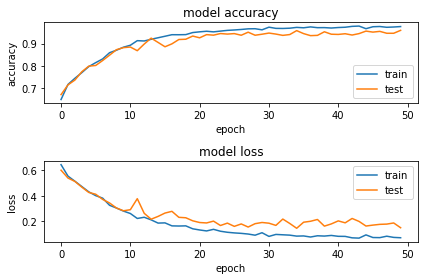

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Alright, so now the model is well trained and ready to be tested by testing data.

In [ ]:
# Test accuracy
score, acc = model.evaluate(predict_data, target_data)
print('Test accuracy:', acc)

4000/4000 [==============================] - 0s 22us/step
Test accuracy: 0.8817499876022339


The testing accuracy is 88%, indicating that the model is decent enough to classify the potential caravan customers. We will have a further investigation on classification performance below.

In [ ]:
# Prediction on testing data
y_pred = np.round(model.predict(predict_data))

In [ ]:
# Generate the classification report
print(classification_report(target_data,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3762
           1       0.15      0.21      0.18       238

    accuracy                           0.88      4000
   macro avg       0.55      0.57      0.56      4000
weighted avg       0.90      0.88      0.89      4000



### Confusion Matrix

In [ ]:
cm = confusion_matrix(target_data,y_pred) # create a confusion matrix

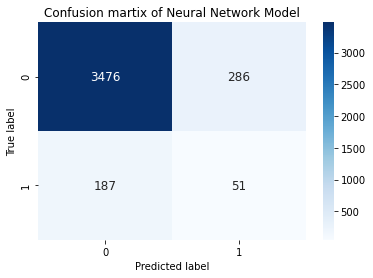

In [ ]:
# Plot the confusion matrix
import seaborn as sns
sns.heatmap(cm,
            cmap=plt.cm.Blues,
            annot=True, 
            annot_kws={"size": 12}, 
            fmt="d") # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion martix of Neural Network Model')
plt.show()

### Result

By applying the model on 4000 testing data, we can observe the model performance from the classification report and confusion matrix below.

#### **Overall performance: 88% accuracy on testing data**
The overall accuracy of the classification is 88%. However, overall accuracy is not the sole measure to evaluate the model performance since the accuracy can be easily achieved by simply classified all data as a negative result in this rare event classification. Therefore, we need to further consider the precision of both positive and negative prediction as well.

#### **Identifying non-target users: 95% precision**
As we expected, the model gives a good result in identifying the negative target (non-users) with 95% accuracy. However, this result does not help a lot to the caravan business since the objective should be identifying potential users. Therefore, we need to consider positive precision.

#### **Identifying target users: 15% precision**
This precision reflects how good is the model to identify positive result, i.e. the potential caravan users. Among 4000 testing data, the model predicts there are 347 potential users and the accuracy of identifying caravan users is 15%.

#### **False positive rate: 7.6%**
False-positive rate reflects the proportion of all negatives that still yield positive test outcomes. A higher false-positive rate means more data are incorrectly identified as potential users. 

This is usually a measure indicating effectiveness when we need to apply marketing strategies to the target group. For instance, when we spend resources to promote caravan to those categorised as potential users according to this model, 7.6% of them would be wasted since they are not caravan customers.

So far we can construct a simple deep learning model with 3 hidden layers to identify potential customers with 88% accuracy. To improve the model, we can always try other combinations of the model setup or some suggests another deep learning - autoencoder, which divides the input into larger network and then re-construct the output with similar as the input. It is believed this can perform well to handle these rare event classifications.  

[Back to top](#Home)